In [118]:
from functions import *
import pandas as pd
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import re
import ppscore as pps
from matplotlib import pyplot as plt

In [2]:
df_training = pd.read_csv("training_data.csv")
df_test = pd.read_csv("forecast_starting_data.csv")
df_macro = pd.read_csv("macro_data.csv")

/var/folders/qk/_5glkdns4bnc7kqq_1grbvd80000gn/T/ipykernel_33057/998706994.py:1: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_training = pd.read_csv("training_data.csv")


# Initial data cleaning and sample creation
To do some preliminary cleaning of the data, we dropped columns with only NaN values. Then, we created our sample dataset that we used to identify relationships and train the model. 50% of this sample contained all the accounts that were charged off in the dataset (15698 values), while the other 50% of this sample contained a random sample of 15698 accounts that weren't charged off in the dataset, for a total of 31396 accounts.

In [3]:
df_training.drop('charge_off_reason_code', axis=1, inplace=True)
df_training.drop('writeoff_date', axis =1, inplace=True)
# dataless_forecast_cols = []
# for column in df_test.columns:
#     if ((len(df_test[column].unique()) == 1) & len(column)):
#         df_test.append(column)
# df_training1.drop(dataless_forecast_cols, axis=1, inplace=True)

In [4]:
df_no_charge_sample = df_training[df_training['charge_off'] == 0].sample(n=15698)
df_charge = df_training[df_training['charge_off'] == 1]
df_tot_sample = pd.concat([df_charge, df_no_charge_sample], axis=0)

In [5]:
data = []
for column in df_tot_sample.columns:
    data.append(pps.score(df_tot_sample, x=column, y="charge_off"))
df_random_pps1 = pd.DataFrame(data)
df_random_pps1 = df_random_pps1.sort_values(by='ppscore', ascending=False).head(n=20)
df_random_pps1

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
20,active,charge_off,1.000000,regression,True,mean absolute error,0.488,0.000000,DecisionTreeRegressor()
21,charge_off,charge_off,1.000000,predict_itself,True,None,0.000,1.000000,None
26,total_writeoff_amt,charge_off,1.000000,regression,True,mean absolute error,0.488,0.000000,DecisionTreeRegressor()
49,writeoff_type_null,charge_off,0.992651,regression,True,mean absolute error,0.488,0.003586,DecisionTreeRegressor()
25,principal_amt_chrg_off,charge_off,0.970488,regression,True,mean absolute error,0.488,0.014402,DecisionTreeRegressor()
27,fee_chg_off_reversal_amt,charge_off,0.873271,regression,True,mean absolute error,0.488,0.061844,DecisionTreeRegressor()
34,fc_reversals,charge_off,0.850726,regression,True,mean absolute error,0.488,0.072846,DecisionTreeRegressor()
22,charge_off_aged,charge_off,0.802494,regression,True,mean absolute error,0.488,0.096383,DecisionTreeRegressor()
35,fee_reversals,charge_off,0.797362,regression,True,mean absolute error,0.488,0.098888,DecisionTreeRegressor()
17,credit_limit_amt,charge_off,0.674198,regression,True,mean absolute error,0.488,0.158991,DecisionTreeRegressor()


# Feature engineering
We incorporate the macro data into our DataFrame to take economic data into cosideration when making our prediction and constructing our model. 

In [6]:
macro_final = pd.DataFrame()
for i, row in df_macro.iterrows():
    if re.search(r"2017$", str(row["Mnemonic"])) or re.search(r"2018$", str(row["Mnemonic"])) or re.search(r"2019$", str(row["Mnemonic"])) or re.search(r"2020$", str(row["Mnemonic"])) or re.search(r"2021$", str(row["Mnemonic"])):
        t1 = pd.DataFrame(row).T
        month_code = format_date(t1['Mnemonic'].iloc[0])
        t1['mth'] = month_code
        macro_final = pd.concat([macro_final, t1], axis=0)

In [13]:
x = pd.DataFrame()
final = pd.DataFrame()
a = 0

for i in df_tot_sample['mth_code'].unique():
    left_block = df_tot_sample[df_tot_sample['mth_code'] == i]
    temp2 = macro_final[macro_final['mth'] == str(i)]
    right_block = pd.concat([temp2] * len(left_block))
    
    left_block = left_block.reset_index(drop=True)
    right_block = right_block.reset_index(drop=True)
    
    x = pd.concat([left_block, right_block], axis=1).reset_index()
    if a == 0:
        final = x
        a += 1
    else:
        final = pd.concat([x, final], axis=0)

# Finding correlation ppscore metrics
In traditional data analysis, the first step to determine any underlying relationships is usually finding the correlation matrix of a sample dataframe. However, the correlation matrix has some limitations, mainly the inability to account for non-linear relationships. Predictive power score (PPS) is an alternative to correlation matrix that has the ability to account for non-linear relationships in its scoring. More documentation and explanation can be found here: https://medium.com/geekculture/predictive-power-score-implementation-in-python-70558bf91f45.
    
We looked at both correlation and ppscore matrices with relation to their ability to predict whether an account will be charged off. From these results, we saw that columns fico_numbers, behaviour_numbers, credit_limit_amt, and prev_balance had the highest ppscore. Additionally, we found that the macro data did not have any high correlation or ppscores, so they minimally impacted our model


In [45]:
data = []
for column in final.columns:
    data.append(pps.score(final, x=column, y="charge_off"))

df_random_pps = pd.DataFrame(data)
df_random_pps = df_random_pps.sort_values(
    by='ppscore', ascending=False).head(n=20)


In [46]:
useless_cols = []
for column in df_test.columns:
    if ((len(df_test[column].unique()) == 1)):
        useless_cols.append(column)
filtered_col_list = [
    col for col in df_training.columns if col not in useless_cols]
data = []
for column in filtered_col_list:
    data.append(pps.score(final, x=column, y="charge_off"))
df_random_pps_filtered = pd.DataFrame(data)
df_random_pps_filtered = df_random_pps_filtered.sort_values(
    by='ppscore', ascending=False).head(n=20)


In [47]:
df_random_pps_filtered.head(n=10)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
21,total_writeoff_amt,charge_off,1.000000,regression,True,mean absolute error,0.4986,0.000000,DecisionTreeRegressor()
20,principal_amt_chrg_off,charge_off,0.976565,regression,True,mean absolute error,0.4986,0.011685,DecisionTreeRegressor()
17,credit_limit_amt,charge_off,0.683002,regression,True,mean absolute error,0.4986,0.158055,DecisionTreeRegressor()
6,bank_fico_buckets_20,charge_off,0.439039,regression,True,mean absolute error,0.4986,0.279695,DecisionTreeRegressor()
1,net_payment_behaviour_tripd,charge_off,0.405252,regression,True,mean absolute error,0.4986,0.296541,DecisionTreeRegressor()
13,prev_balance,charge_off,0.385327,regression,True,mean absolute error,0.4986,0.306476,DecisionTreeRegressor()
10,nbr_mths_due,charge_off,0.324312,regression,True,mean absolute error,0.4986,0.336898,DecisionTreeRegressor()
15,net_payments,charge_off,0.279435,regression,True,mean absolute error,0.4986,0.359274,DecisionTreeRegressor()
12,stmt_balance,charge_off,0.215062,regression,True,mean absolute error,0.4986,0.391370,DecisionTreeRegressor()
19,principal_amt,charge_off,0.210049,regression,True,mean absolute error,0.4986,0.393870,DecisionTreeRegressor()


# Cleaning
We further cleaned the data by converting the fico bucket ranges into averages and converting the payment behavior of accounts to numerical categories

In [55]:
# converting fico bucket ranges into averages
final['bank_fico_buckets_20'].unique()
data = {'bank_fico_buckets_20': ['681-700', '621-640', '721-740', '601-620', '661-680',
                                 '681-700', '561-580', '761+', '<= 560', '701-720', 'Missing', 'Exception']}



def convert_range_to_number(range_str):
    if range_str in ['Missing', 'Exception']:
        return 690
    elif range_str == '761+':  
        return 761
    elif range_str == '<= 560':
        return 560
    else:
        range_parts = range_str.split('-')
        return (int(range_parts[0]) + int(range_parts[1])) / 2


final['fico_numbers'] = final['bank_fico_buckets_20'].apply(convert_range_to_number)


In [60]:
# converting net_payment_behaviour_tripd to numerical categories
data = {'net_payment_behaviour_tripd': ['D', 'P', 'R', 'I', 'T', 'C']}

data = {'D': 0, 'P': 1, 'R': 2, 'I': 3, 'T': 4, 'C': 5}

final['behaviour_numbers'] = final['net_payment_behaviour_tripd'].replace(data)

# Adding in time features
We did feature engineering to find the survival times, assign each month a number ranging from 1 to 24, sort the data values, and remove multiple occurences of same observations so that only the observations in which people are charged off or in which the last observations of the people which don't get charged off are remaining. This prepares the data to be applied to the Cox Proportional Hazards Model.

In [69]:
final = add_survival_time(final)
final = add_month_nums(final)
final = sort_by_mth_and_snapshot(final)
final = get_uniques(final)
final = final.reset_index()
final.drop('index', axis=1, inplace=True)

In [70]:
final

,level_0,financial_active,net_payment_behaviour_tripd,promotion_flag,variable_rate_index,account_status_code,active_12_mths,bank_fico_buckets_20,mob,open_closed_flag,...,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA,mth,survival_time,month_num,max_survival_time,fico_numbers,behaviour_numbers
0,0,1.0,D,0,1,A,1.0,681-700,24,0.0,...,4.206673162,64.29943946,783.2181714,611.3780129,201802,1,2,23,690.5,0
1,8,1.0,P,0,1,A,1.0,721-740,30,1.0,...,4.206673162,64.29943946,783.2181714,611.3780129,201802,1,2,23,730.5,1
2,9,1.0,I,0,0,A,1.0,601-620,15,1.0,...,4.206673162,64.29943946,783.2181714,611.3780129,201802,1,2,23,610.5,3
3,10,1.0,R,0,0,A,1.0,<= 560,11,0.0,...,4.206673162,64.29943946,783.2181714,611.3780129,201802,1,2,23,560.0,2
4,11,1.0,D,0,0,A,1.0,581-600,25,1.0,...,4.206673162,64.29943946,783.2181714,611.3780129,201802,1,2,23,590.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16880,15640,0.0,C,1,1,I 0-6,1.0,761+,14,1.0,...,3.760471113,65.0603319,817.510954,599.0520692,201912,17,24,17,761.0,5
16881,15639,1.0,D,1,1,A,1.0,741-760,32,1.0,...,3.760471113,65.0603319,817.510954,599.0520692,201912,17,24,17,750.5,0
16882,15553,0.0,P,1,0,A,1.0,641-660,555,1.0,...,3.760471113,65.0603319,817.510954,599.0520692,201912,18,24,18,650.5,1
16883,15536,1.0,P,1,0,A,1.0,661-680,28,0.0,...,3.760471113,65.0603319,817.510954,599.0520692,201912,10,24,10,670.5,1


In [82]:
final["net_payment_behaviour_tripd"].unique()

array(['D', 'P', 'I', 'R', 'T', 'C'], dtype=object)

# Adjusting forecast dataset
fico_numbers
behaviour_numbers
credit_limit_amt
prev_balance


In [109]:
df_test['bank_fico_buckets_20']
data = {'bank_fico_buckets_20': ['681-700', '621-640', '721-740', '601-620', '661-680',
                                 '681-700', '561-580', '761+', '<= 560', '701-720', 'Missing', 'Exception']}


df_test['fico_numbers'] = df_test['bank_fico_buckets_20'].apply(
    convert_range_to_number)


In [110]:
data = {'net_payment_behaviour_tripd': ['D', 'P', 'R', 'I', 'T', 'C']}

data = {'D': 0, 'P': 1, 'R': 2, 'I': 3, 'T': 4, 'C': 5}

df_test['behaviour_numbers'] = df_test['net_payment_behaviour_tripd'].replace(data)


# Cox Proportional Hazard Model
The Cox Proportional Hazard Model is a parametric model in survival analysis that takes into account multiple variables to analyze their relationship to their survival distribution.




In [111]:
df_clean_train_final = final
columns = ["survival_time", "charge_off", "fico_numbers", "behaviour_numbers", "credit_limit_amt", "prev_balance"]
dfcox = df_clean_train_final[columns]
coxph = CoxPHFitter()
coxph.fit(dfcox, duration_col='survival_time', event_col='charge_off')
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 16885 total observations, 1187 right-censored observations>
             duration col = 'survival_time'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 16885
number of events observed = 15698
   partial log-likelihood = -137247.21
         time fit was run = 2023-03-26 08:59:33 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
fico_numbers       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
behaviour_numbers  -0.18       0.84       0.01            -0.19            -0.16                 0.82                 0.85
credit_limit_amt   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
prev_balance        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

                    cmp to      z      p   -log2(p)
covariate                                          
fico_numbers          0.00 -20.93 <0.005     320.60
behaviour_numbers     0.00 -21.73 <0.005     345.40
credit_limit_amt      0.00 -15.81 <0.005     184.68
prev_balance          0.00   5.28 <0.005      22.92
---
Concordance = 0.58
Partial AIC = 274502.43
log-likelihood ratio test = 1904.50 on 4 df
-log2(p) of ll-ratio test = inf

In [177]:
survival_functions = coxph.predict_survival_function(df_test)
survival_functions = survival_functions.loc[1:12, :]
survival_functions

,0,1,2,3,4,5,6,7,8,9,...,19856,19857,19858,19859,19860,19861,19862,19863,19864,19865
1.0,0.978793,0.952660,0.985510,0.946437,0.967739,0.942801,0.944455,0.977941,0.957284,0.970422,...,0.964860,0.965809,0.965530,0.987846,0.970969,0.956558,0.961916,0.973740,0.954509,0.971315
2.0,0.956765,0.904841,0.970352,0.892695,0.934620,0.885639,0.888845,0.955049,0.913919,0.939971,...,0.928895,0.930781,0.930226,0.975102,0.941064,0.912490,0.923062,0.946608,0.908465,0.941754
3.0,0.934394,0.857681,0.954845,0.840069,0.901398,0.829895,0.834513,0.931823,0.870927,0.909333,...,0.892934,0.895719,0.894900,0.962031,0.910956,0.868838,0.884339,0.919209,0.862961,0.911982
4.0,0.910835,0.809531,0.938385,0.786741,0.866861,0.773657,0.779588,0.907386,0.826788,0.877381,...,0.855678,0.859354,0.858272,0.948117,0.879538,0.824060,0.844363,0.890524,0.816398,0.880901
5.0,0.885678,0.759825,0.920658,0.732138,0.830503,0.716350,0.723497,0.881322,0.780947,0.843628,...,0.816603,0.821166,0.819822,0.933089,0.846325,0.777599,0.802595,0.860092,0.768214,0.848031
6.0,0.860105,0.711090,0.902472,0.679068,0.794099,0.660938,0.669133,0.854857,0.735711,0.809708,...,0.777635,0.783032,0.781442,0.917623,0.812923,0.731797,0.761110,0.829369,0.720849,0.814956
7.0,0.832722,0.660897,0.882807,0.624923,0.755751,0.604715,0.613835,0.826554,0.688795,0.773833,...,0.736761,0.742976,0.741144,0.900843,0.777566,0.684346,0.717786,0.796716,0.671931,0.779930
8.0,0.806679,0.615054,0.863912,0.575953,0.719894,0.554158,0.563978,0.799671,0.645634,0.740149,...,0.698711,0.705634,0.703592,0.884661,0.744341,0.640743,0.677640,0.765900,0.627122,0.746997
9.0,0.779237,0.568729,0.843789,0.526966,0.682767,0.503883,0.514267,0.771382,0.601691,0.705123,...,0.659496,0.667089,0.664848,0.867366,0.709763,0.596401,0.636460,0.733687,0.581706,0.712704
10.0,0.749942,0.521500,0.822057,0.477577,0.643894,0.453526,0.464325,0.741229,0.556520,0.668276,...,0.618643,0.626867,0.624438,0.848612,0.673351,0.550880,0.593782,0.699602,0.535252,0.676571


In [178]:
aggregate_survival = survival_functions.mean(axis = 1)

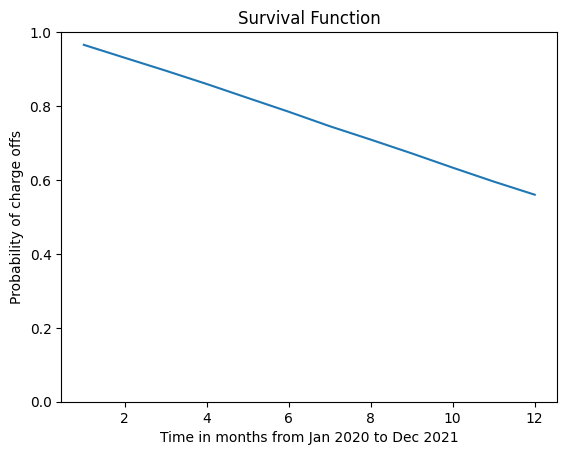

In [185]:
plt.plot(aggregate_survival.index, aggregate_survival.values)
plt.ylim(0, 1)
plt.xlabel('Time in months from Jan 2020 to Dec 2021')
plt.ylabel('Probability of charge offs')
plt.title('Survival Function')
plt.show()

In [180]:
start = 1
end = 12
num_charge_offs = survival_functions.loc[start:end, :].diff().iloc[-1].sum() *-1
num_charge_offs

706.130809187375

In [184]:
for i in range(1,12):
    start = i 
    end = i + 1
    print(survival_functions.loc[start:end, :].diff().iloc[-1].sum() * (-1/12))

58.05289418902419
57.82282600237745
59.673862181571025
62.342357874902135
61.93009259883405
64.71044752192775
60.020368312072506
61.65106072418564
64.02128868506139
62.23115735062375
58.844234098947915
